### _Symptom2Disease using BERT Transformer:_ 
The goal of this project is to see if I can train a model that can predict what disease a person has based on text input about symptoms. This is called NLP or Natural Language Processing. There are many methods used to clean and analyze text input but the methods I will be using in this notebook pertain specificifically to keras, deep learning, and utilization of the BERT transformer. I am still a novice in this area but am striving to become an expert soon.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import os
from tqdm.notebook import tqdm
import re
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from google.colab import drive
drive.mount('/content/drive')

sns.set_palette('Set2')

Mounted at /content/drive


In [6]:
filepath = '/content/drive/MyDrive/Symptoms_and_Disease(NLP)/Data/Symptom2Disease.csv'

symp = pd.read_csv(filepath).drop(columns = 'Unnamed: 0')

In [7]:
symp.head(10)

,label,text
0,Psoriasis,I have been experiencing a skin rash on my arm...
1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,Psoriasis,I have been experiencing joint pain in my fing...
3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,Psoriasis,"My nails have small dents or pits in them, and..."
5,Psoriasis,The skin on my palms and soles is thickened an...
6,Psoriasis,"The skin around my mouth, nose, and eyes is re..."
7,Psoriasis,My skin is very sensitive and reacts easily to...
8,Psoriasis,I have noticed a sudden peeling of skin at dif...
9,Psoriasis,The skin on my genitals is red and inflamed. I...


In [8]:
symp.label.nunique()

24

In [9]:
symp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1200 non-null   object
 1   text    1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB


In [10]:
symp.shape

(1200, 2)

In [11]:
symp.label.value_counts()

Psoriasis                          50
Varicose Veins                     50
peptic ulcer disease               50
drug reaction                      50
gastroesophageal reflux disease    50
allergy                            50
urinary tract infection            50
Malaria                            50
Jaundice                           50
Cervical spondylosis               50
Migraine                           50
Hypertension                       50
Bronchial Asthma                   50
Acne                               50
Arthritis                          50
Dimorphic Hemorrhoids              50
Pneumonia                          50
Common Cold                        50
Fungal infection                   50
Dengue                             50
Impetigo                           50
Chicken pox                        50
Typhoid                            50
diabetes                           50
Name: label, dtype: int64

In [12]:
symp.duplicated().sum()

47

In [13]:
#Confirming there are no actual duplicates in the text column
symp[symp.duplicated()].head(15)

,label,text
163,Chicken pox,I'm feeling fatigued and have no energy. I can...
387,Common Cold,I've been quite exhausted and ill. My throat h...
430,Pneumonia,"I have a really high fever, and I have problem..."
433,Pneumonia,I'm having a hard time breathing and I feel re...
438,Pneumonia,"Lately I've been experiencing chills, fatigue,..."
469,Dimorphic Hemorrhoids,I've been constipated and it's really hard to ...
470,Dimorphic Hemorrhoids,"Since I've been constipated, using the restroo..."
471,Dimorphic Hemorrhoids,I've been constipated and it's really hard to ...
487,Dimorphic Hemorrhoids,Lately I've been experiencing constipation and...
489,Dimorphic Hemorrhoids,I've recently been suffering from constipation...


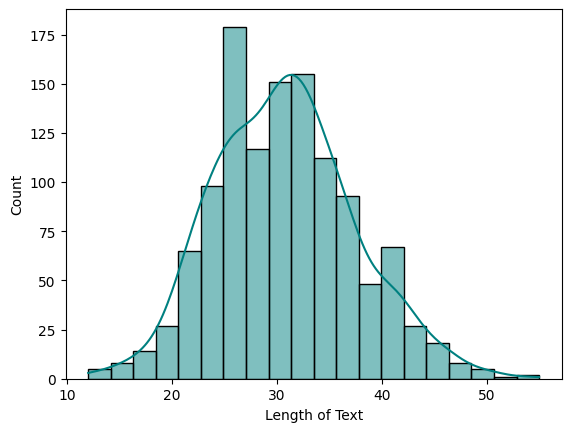

In [14]:
#Histogram of text length for entire text column
text_length = symp.text.apply(lambda x: len(x.split(' ')))

sns.histplot(text_length, color= 'teal', kde=True, bins= 20)
plt.xlabel('Length of Text')
plt.show()

Now I will start transforming everything to get ready to run the BERT Transformer. The process to get the data ready for modeling is as follows:

  1. Encode the labels
 
  2. Tokenize with padding
 
  3. Split data in to train and validation sets
 
  4. Fit the BERT Transformer

In [18]:
int2label = {}

for i, disease in enumerate(symp['label'].unique()):
    int2label[i] = disease

label2int = {v : k for k, v in int2label.items()}
num_classes = len(int2label)

int2label, label2int

({0: 'Psoriasis',
  1: 'Varicose Veins',
  2: 'Typhoid',
  3: 'Chicken pox',
  4: 'Impetigo',
  5: 'Dengue',
  6: 'Fungal infection',
  7: 'Common Cold',
  8: 'Pneumonia',
  9: 'Dimorphic Hemorrhoids',
  10: 'Arthritis',
  11: 'Acne',
  12: 'Bronchial Asthma',
  13: 'Hypertension',
  14: 'Migraine',
  15: 'Cervical spondylosis',
  16: 'Jaundice',
  17: 'Malaria',
  18: 'urinary tract infection',
  19: 'allergy',
  20: 'gastroesophageal reflux disease',
  21: 'drug reaction',
  22: 'peptic ulcer disease',
  23: 'diabetes'},
 {'Psoriasis': 0,
  'Varicose Veins': 1,
  'Typhoid': 2,
  'Chicken pox': 3,
  'Impetigo': 4,
  'Dengue': 5,
  'Fungal infection': 6,
  'Common Cold': 7,
  'Pneumonia': 8,
  'Dimorphic Hemorrhoids': 9,
  'Arthritis': 10,
  'Acne': 11,
  'Bronchial Asthma': 12,
  'Hypertension': 13,
  'Migraine': 14,
  'Cervical spondylosis': 15,
  'Jaundice': 16,
  'Malaria': 17,
  'urinary tract infection': 18,
  'allergy': 19,
  'gastroesophageal reflux disease': 20,
  'drug reacti

In [21]:
#Mapping labels to their integer representation
symp['label'] = symp['label'].map(lambda x : label2int[x])

In [24]:
# Get the text and label data
X = symp['text'].values
y = symp['label'].values

# Initialize the Tokenizer
x_tokenizer = Tokenizer(filters='')

# Fit the Tokenizer on the text data
x_tokenizer.fit_on_texts(X)

# Calculate the vocabulary size
x_vocab = len(x_tokenizer.word_index) + 1
print("X vocab:", x_vocab)

X vocab: 2414


In [25]:
#Test Train Split: Make sure to stratify because we do not want to scramble the sequences. Context matters
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.1, stratify = y)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((1080,), (120,), (1080,), (120,))

In [28]:
!pip install transformers
from transformers import AutoTokenizer
BATCH_SIZE = 8

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
train_encodings = tokenizer(list(train_x), padding="max_length", truncation=True)
val_encodings = tokenizer(list(val_x), padding="max_length", truncation=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_y
)).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_y
)).batch(BATCH_SIZE)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00


Now that we have the train and validation sets encoded for use with Keras, we will fit the BERT Transformer. SparseCatCrossEntropy will be utilized for the Loss function and the Adam optimizer will be used for activation.

In [29]:
num_classes = 24

from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-cased", 
    num_labels = num_classes, 
    id2label = int2label, 
    label2id = label2int,
    output_attentions = True)

model.compile(
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = keras.optimizers.Adam(learning_rate = 3e-5),
    metrics = ['accuracy'])

model

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
#printing layer objects and trainable status
for layer in model.layers:
    print(layer, layer.trainable)

<transformers.models.bert.modeling_tf_bert.TFBertMainLayer object at 0x7fca03440dc0> True
<keras.layers.regularization.dropout.Dropout object at 0x7fca031aafb0> True
<keras.layers.core.dense.Dense object at 0x7fca031ab3a0> True


In [31]:
#Fine tuning the model by adding epochs. Because this is just a test, I will keep the epochs low
EPOCHS = 3

history = model.fit(train_dataset, 
          epochs = EPOCHS, 
          validation_data = val_dataset)

Epoch 1/3
135/135 [==============================] - 203s 1s/step - loss: 2.5306 - accuracy: 0.4269 - val_loss: 1.4976 - val_accuracy: 0.7667
Epoch 2/3
135/135 [==============================] - 128s 945ms/step - loss: 0.9633 - accuracy: 0.8787 - val_loss: 0.5364 - val_accuracy: 0.9083
Epoch 3/3
135/135 [==============================] - 127s 944ms/step - loss: 0.3456 - accuracy: 0.9731 - val_loss: 0.2453 - val_accuracy: 0.9667


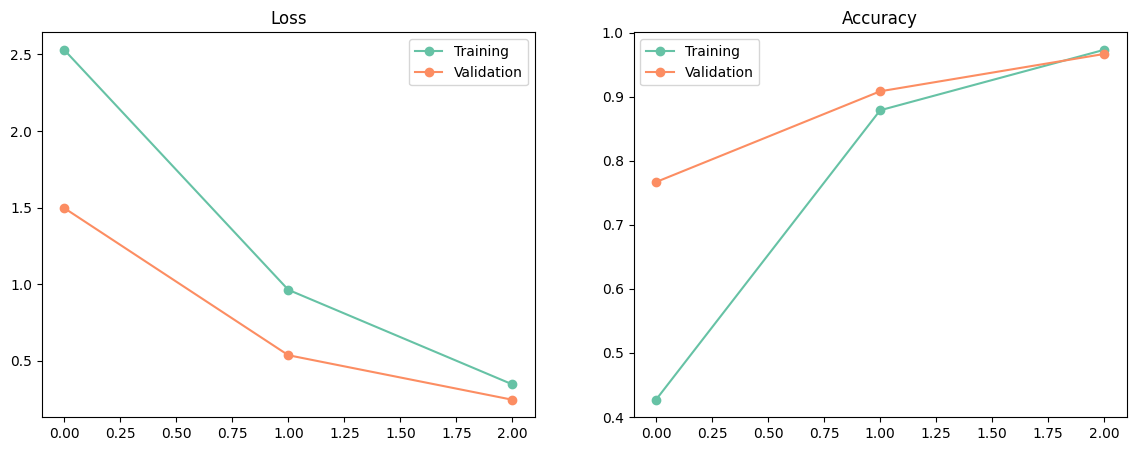

In [32]:
#Plotting our results
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

As we can see from above training and validation accuracy's converge around 2 epochs with an of .973. Not bad for my first BERT usage. I will check the model on unseen input next.

In [33]:
#Will test the model on custom input to see its effectiveness. This will give the suspected disease and its score for how accurately the model predicts
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k = num_classes)
pred1 = pipe("I am experiencing rashes on my skin. It is itchy and is now swelling. Even my sking is starting to peel. ")
pred2 = pipe("I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.")


print(pred1[0][:2])
print(pred2[0][:2])

[{'label': 'Psoriasis', 'score': 0.906468391418457}, {'label': 'Fungal infection', 'score': 0.016016941517591476}]
[{'label': 'Typhoid', 'score': 0.8891716599464417}, {'label': 'Jaundice', 'score': 0.01806272380053997}]


As for next steps, I will try this same process on another dataset to confirm I am understanding what is going on. Also, I would like to work on a streamlit app just for practice. Thanks for following along!